In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

We want to show that the problem above **(1)** is equivalent to the following primal SVM problem **(2)**: 

$$ min_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \frac{1}{2}\sum_{j=1}^{m}w_j^2 + C\sum_{i=1}^{n}\xi_i $$

with the constraints : $\forall i \in \{ 0,...n \} $ $$\xi_i \geq 0$$ and $$ y_i (w^T x_i) + b \geq 1 - \xi_i$$

________

To show that, let's prove (1) < (2) and then (2) < (1), showing that the problem are equivalent. 

- First, let's proove **(1) < (2)** : 

For $w \ \in \ \mathbb{R^m}, w_0 \ \in \ \mathbb{R} \ $and$ \ \xi_i \ \in \ \mathbb{R^n}$$ 
 Such that $\xi_i > 0$ and $xi_i > 1 - y_i(\langle w , \Phi(x_i)\rangle + w_0), \  \forall i \in \{1,...,n\} $

Therefore, $$\xi_i > max(0,1 - y_i(\langle w , \Phi(x_i)\rangle+ w_0))$$

Then, $$ C\sum_{i=1}^{n}\xi_i > C\sum_{i=1}^{n}max(0,1 - y_i(\langle w , \Phi(x_i)\rangle + w0))$$

We have **(1) > (2)**

- Now, let's proove **(2) < (1)** : 

For $\ w \ \in \ \mathbb{R^m}, w_0 \ \in \ \mathbb{R}$

$$ \xi_i = max(0,1 - y_i(\langle w , \Phi(x_i)\rangle + w_0)) $$ 

We have, $$ \xi_i \geq 0 $$ and $$ \xi_i > 1 - y_i(\langle w , \Phi(x_i)\rangle + w_0), \  \forall i \in \{1,...,n\} $$ 

$$\frac{1}{2}\sum_{j=1}^{m}w_j^2 + c\sum_{i=1}^{n}max(0,1 - y_i(\langle w , \Phi(x_i)\rangle + w_0)) = \frac{1}{2}\sum_{j=1}^{m}\nu_j^2 + c\sum_{i=1}^{n}\xi_i$$


Therefore, $$ \frac{1}{2}\sum_{j=1}^{m}w_j^2 + c\sum_{i=1}^{n} [ 1 - y_i(\langle w , \Phi(x_i)\rangle + w_0)) ]_+> min_{w,w_0,\xi} (\frac{1}{2}\sum_{j=1}^{m}w_j^2 + c\sum_{i=1}^{n}\xi_i) $$

By taking the min of the left term, we get **(2) > (1)**

**=> Therefore, we have shown that the primal SVM problem and the problem above are equivalent.**

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

An SVM allows an upper bound to the classification error, because it takes into account only the data that is not to far from the Hyperplane. The data that is too far will not be considered for the SVM, this is why it is called an upper bound. The hyperplane are made according to the function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$, which is a convex function. This is why we call it a 'convex upper bound'. 

Pivotal loss is equivalent to the Hinge loss which is $ l(y) = max(0,1-t.y)$ for $t= +1$ or $t=-1$. It is a type of binary loss function. Binary classification is a more global type of loss function. 
 

## Example of using SVC (originally in ```svm_script.py```)

In [2]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=30, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

<IPython.core.display.Javascript object>


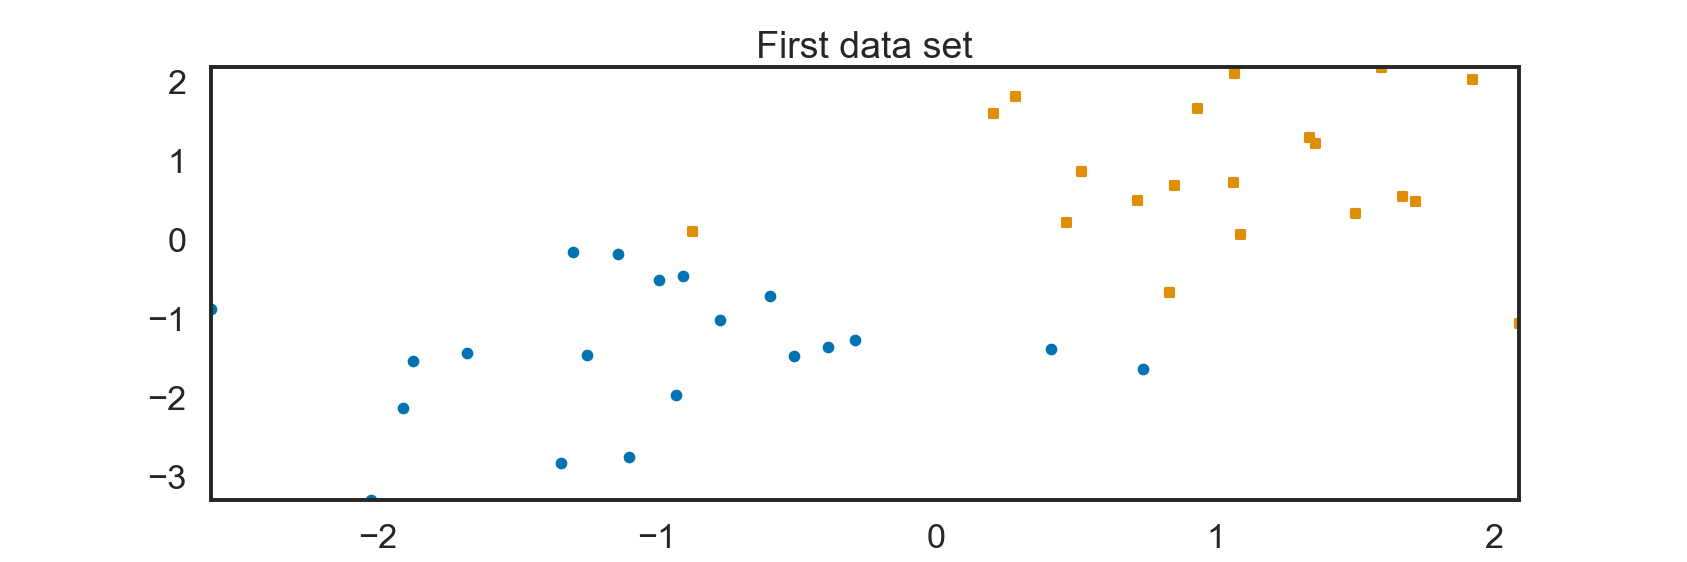

Score : 0.95


<IPython.core.display.Javascript object>


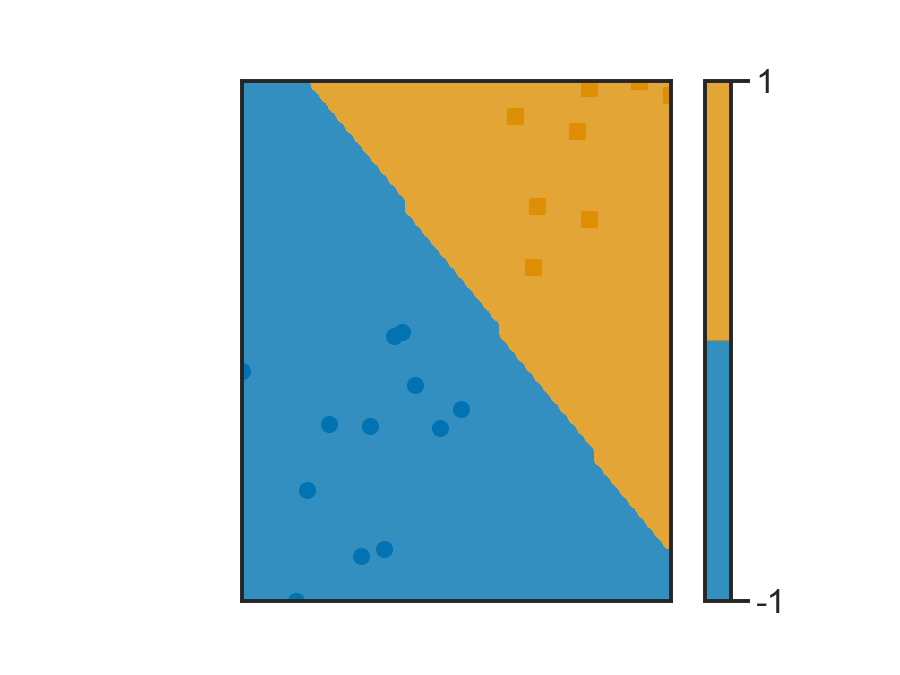

In [3]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

In [4]:
from sklearn.datasets import make_blobs

X2, y2 = make_blobs(n_samples=100, n_features=2, cluster_std=1,
                  centers=[(1, 1), (-1, -1)], shuffle=False)

y2[:50] = -1
i=np.random.randint(100)
np.random.seed(i)
np.random.shuffle(y2)
np.random.seed(i)
np.random.shuffle(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25)

<IPython.core.display.Javascript object>


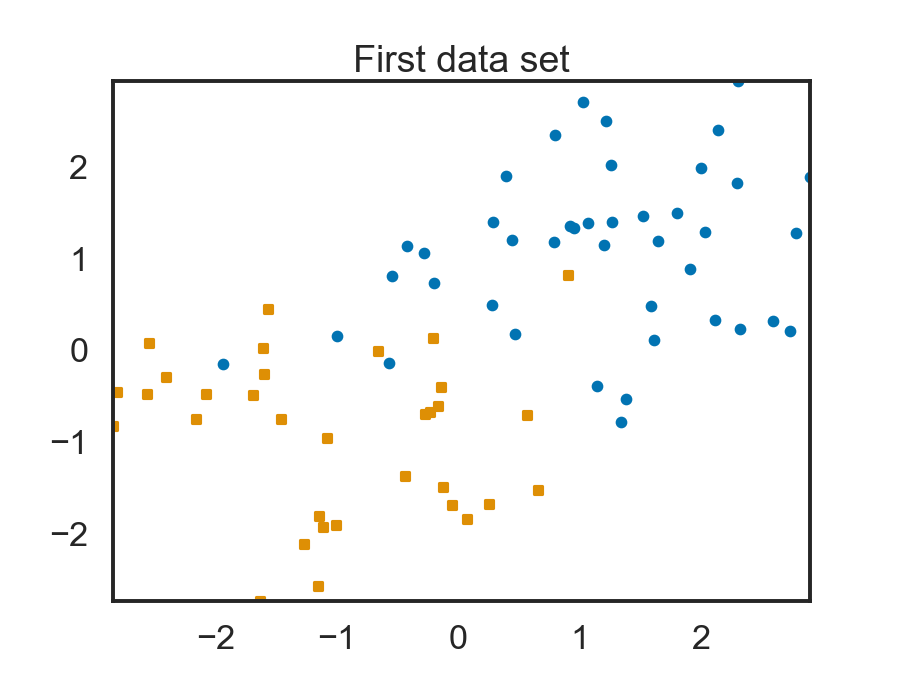

In [5]:
plt.close("all")
plt.title('First data set')
plot_2d(X_train2, y_train2)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [6]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
n_mc = 10000
empiric_risk = 0
for i in range(n_mc):
    rand = np.random.random()
    if rand < 1/2 : 
        x = np.random.multivariate_normal((1, 1), np.eye(2), 1)
    else : 
        x = np.random.multivariate_normal((-1 ,-1), np.eye(2), 1)
    p1 = multivariate_normal.pdf(x, mean = (1, 1), cov = np.eye(2))
    p2 = multivariate_normal.pdf(x, mean = (-1, -1), cov = np.eye(2))
    eta = 3*p1/4*(p1+p2)
    empiric_risk+= min(eta, 1-eta)
    
empiric_risk = empiric_risk/n_mc

print("Estimated Bayes risk :", empiric_risk)

Estimated Bayes risk : 0.0038489806198694814


**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<IPython.core.display.Javascript object>


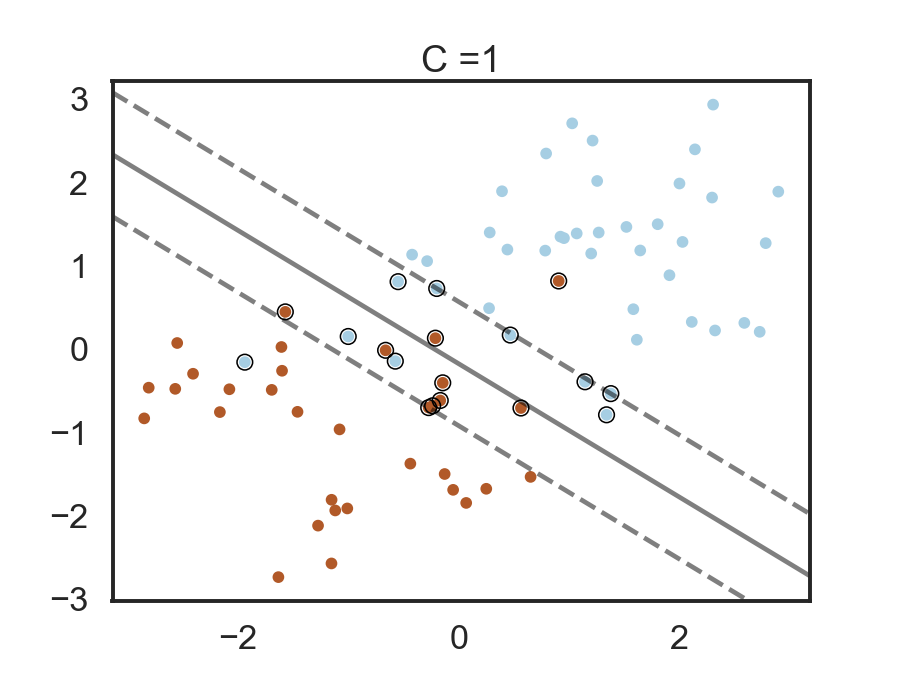

<IPython.core.display.Javascript object>


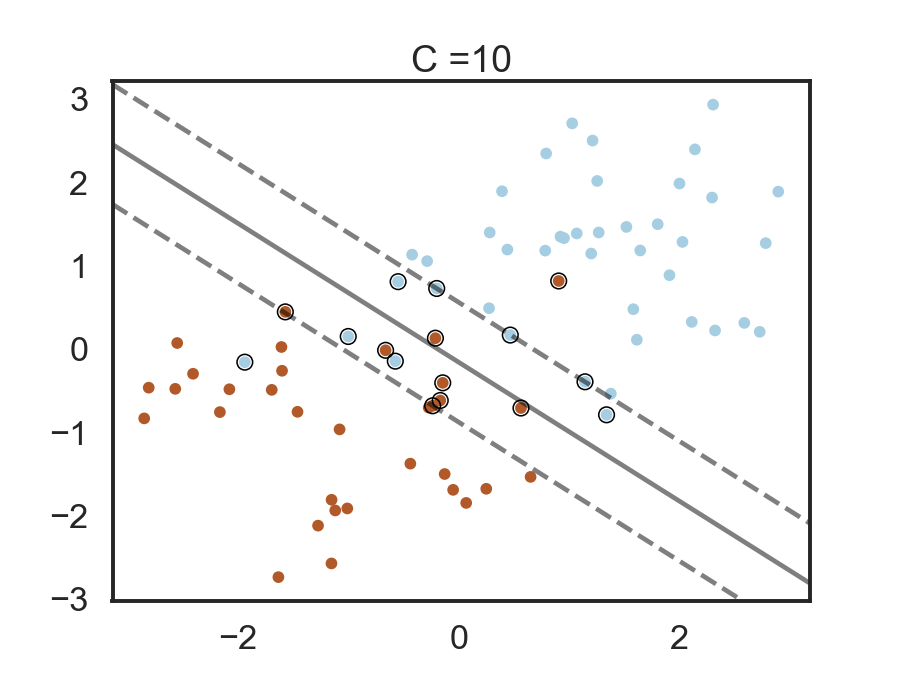

<IPython.core.display.Javascript object>


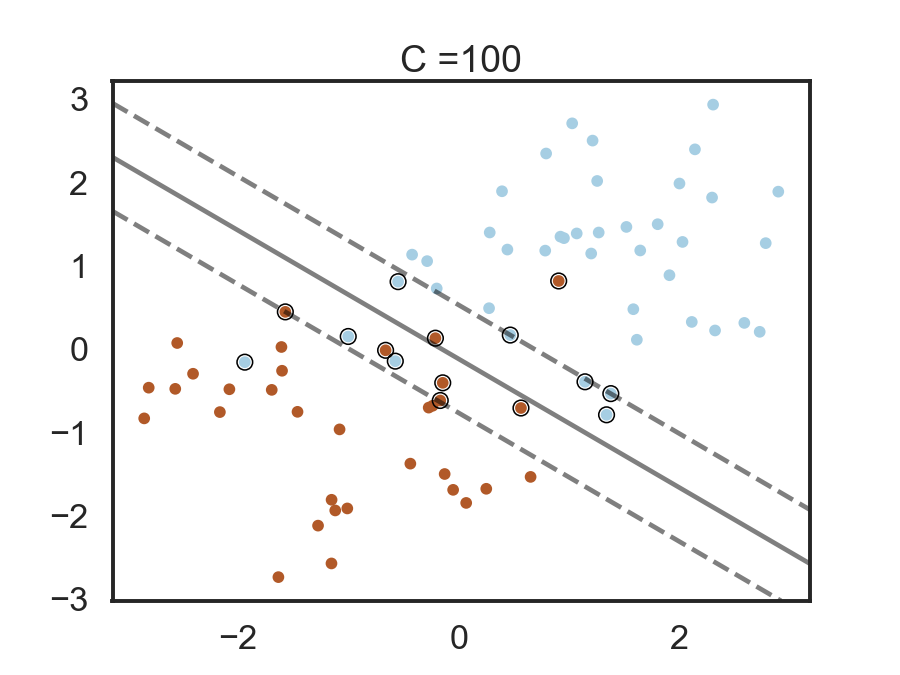

<IPython.core.display.Javascript object>


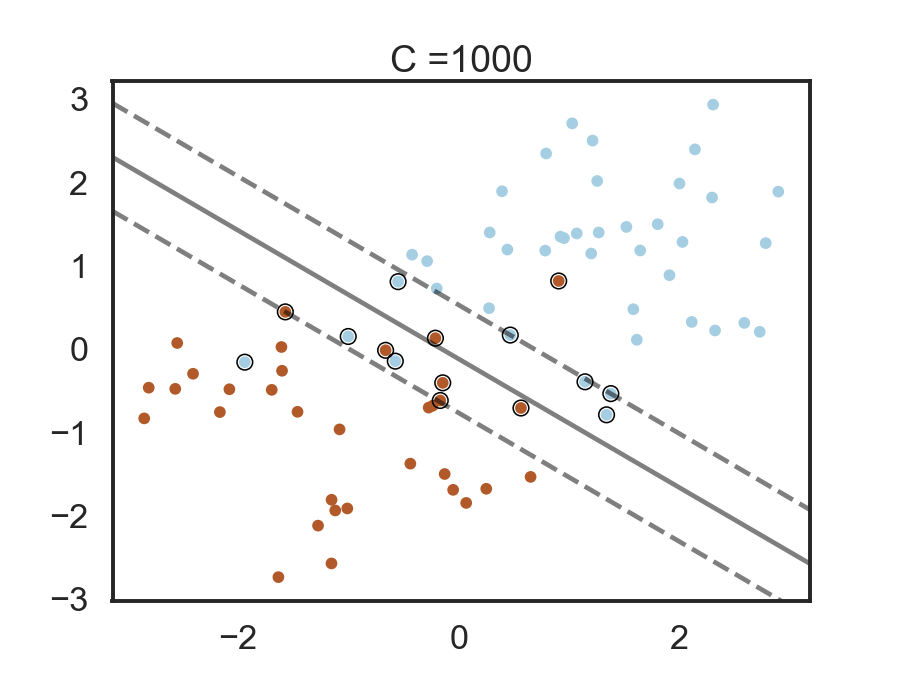

In [7]:
# fit the model, don't regularize for illustration purposes
C_list=[1, 10, 100, 1000]
plt.close("all")
for i in range(len(C_list)):
    plt.figure(i)
    plt.title("C =" + str(C_list[i]))
    clf = SVC(kernel='linear', C=C_list[i])
    clf.fit(X_train2, y_train2)
    plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train2, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Here the parameter C doesn't have an impact on the support vectors, they are the same since the data has not different possibility of separtion. When C is small there is a bigger margin and the support vectors are less closed to the margin boundaries.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

<IPython.core.display.Javascript object>


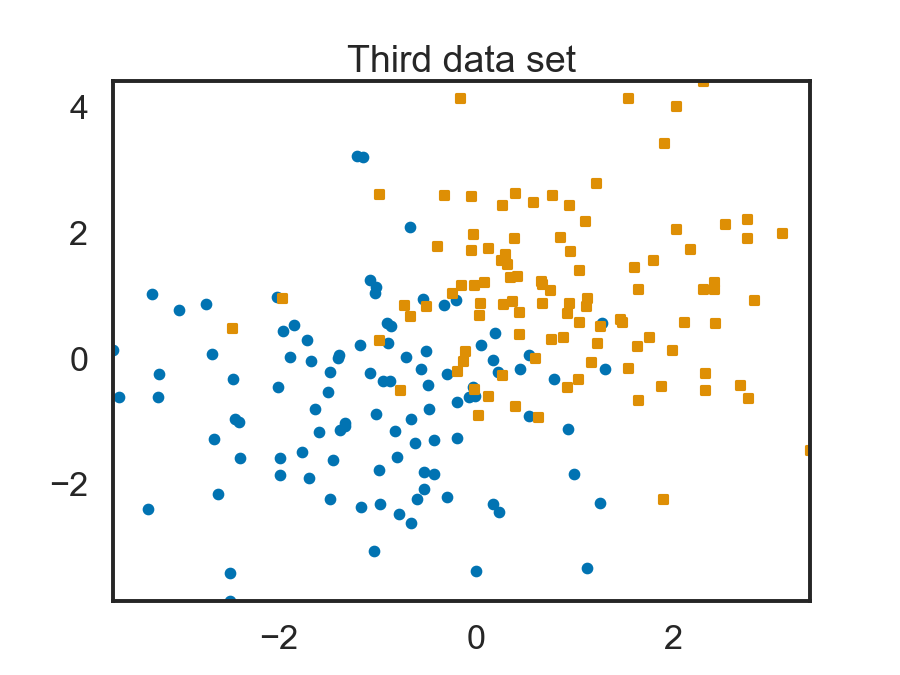

In [8]:
# Generate data and verify graphically that the two classes overlap
X3, y3 = make_blobs(n_samples=200, n_features=2, cluster_std=1.2,
                  centers=[(-1, -1), (1, 1)], shuffle=False)

y3[:100]= -1
i=np.random.randint(100)
np.random.seed(i)
np.random.shuffle(y3)
np.random.seed(i)
np.random.shuffle(X3)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25)


plt.close("all")
plt.title('Third data set')
plot_2d(X3, y3)

In [9]:
# Find the best working C with a 5-fold cross-validation
p_grid_svm = {'C': [1,2,3,4,5,6,7,8,9,1e1,1e2,1e3]}
LSVM = SVC(kernel='linear')
grid_svm = GridSearchCV(estimator= LSVM, param_grid=p_grid_svm, cv=5 )
grid_svm.fit(X_train3, y_train3)
print("Best training Score: {}".format(grid_svm.best_score_))
print("Best training params: {}".format(grid_svm.best_params_))

train_scoreLSVM = grid_svm.best_score_
test_scoreLSVAM =  grid_svm.score(X_test3, y_test3)


print("Score for the test set :", grid_svm.score(X_test3, y_test3))

Best training Score: 0.86
Best training params: {'C': 6}
Score for the test set : 0.86


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

In [10]:
# Vary the parameter of the kernel and check the difference between training and testing scores
from sklearn.metrics import accuracy_score
p_grid_nlsvm = {'C': [1,2,3,4,5,6,7,8,9,1e1,1e2,1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, cv=5 )
grid_nlsvm.fit(X_train3, y_train3)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test3)
print("Score for the test set :", grid_nlsvm.score(X_test3, y_test3))

Best training Score: 0.8733333333333333
Best training params: {'C': 3, 'gamma': 0.0005}
Score for the test set : 0.86


Here we see that the score for the training set is higher than with linear kernel, but the score on the test set are the same. So the gaussian kernel SVM fit too much on the train data. It shows indeed that using a gaussian kernel can overfit but the most important is that we increase the dimensionality when it is not needed.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

<IPython.core.display.Javascript object>


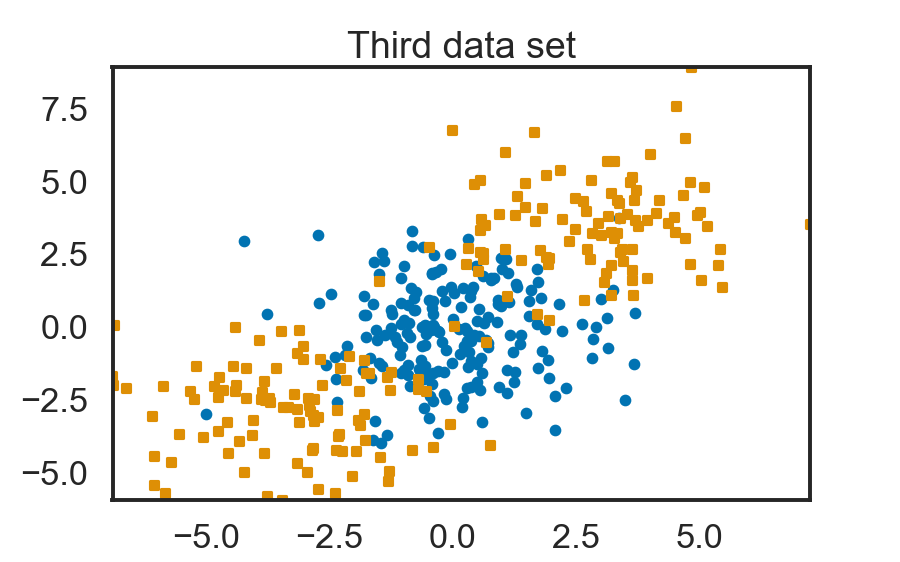

In [11]:
C0, c0 = make_blobs(n_samples=200, n_features=2, cluster_std=1.5,
                  centers=[(0,0)],shuffle=False)
C1, c1 = make_blobs(n_samples=200, n_features=2, cluster_std=1.5,
                  centers=[(-3, -3), (3,3)],shuffle=False)
c1[:]=1

X4 = np.concatenate((C0, C1))
y4 = np.concatenate((c0, c1))


y4[:200]=-1
i=np.random.randint(200)
np.random.seed(i)
np.random.shuffle(y4)
np.random.seed(i)
np.random.shuffle(X4)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25)
plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(8, 5))
plt.title('Third data set')
plot_2d(X4, y4)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

Best training Score: 0.9
Best training params: {'C': 1, 'gamma': 0.1}
Score for the test set : 0.91


<IPython.core.display.Javascript object>


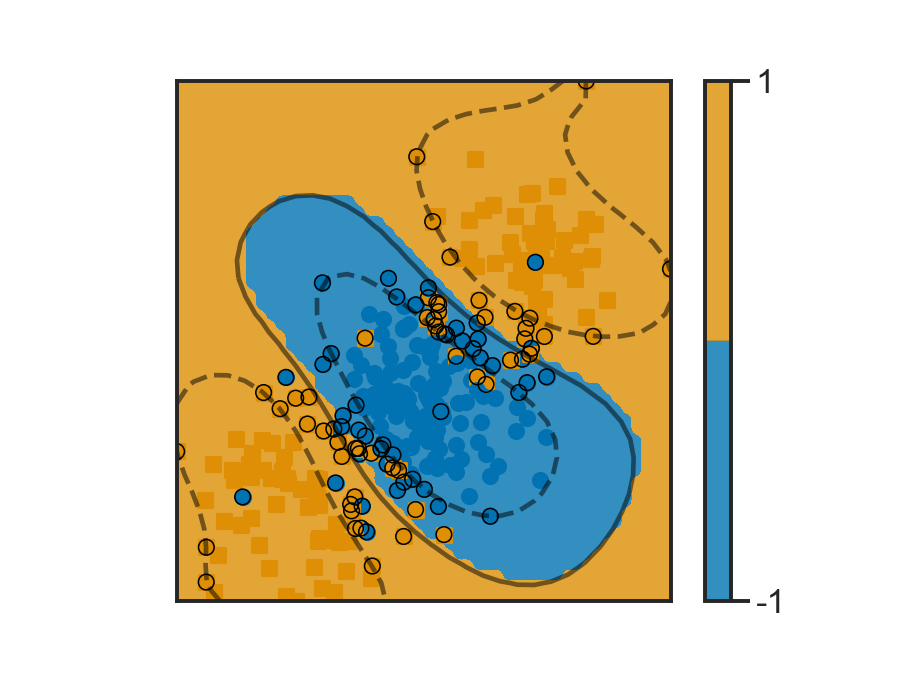

In [12]:
#GAUSSIAN
plt.close("all")
p_grid_nlsvm = {'C': [1,2,3,4,5,6,7,8,9,1e1,1e2,1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, cv=5 )
grid_nlsvm.fit(X_train4, y_train4)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

train_scoreRBF = grid_nlsvm.best_score_
test_scoreRBF = grid_nlsvm.score(X_test4, y_test4)


print("Score for the test set :", grid_nlsvm.score(X_test4, y_test4))

def f(xx):
    """Classifier"""
    return int(grid_nlsvm.predict(xx.reshape(1, -1)))
frontiere(f, X_train4, y_train4, w=None, step=50, alpha_choice=1)

# plot the decision function
clf = SVC(kernel='rbf',C=grid_nlsvm.best_params_["C"],gamma=grid_nlsvm.best_params_["gamma"])
clf.fit(X_train4, y_train4)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
      linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
sv_RBF = len(clf.support_vectors_)
plt.show()

Best training Score: 0.6266666666666667
Best training params: {'C': 2, 'gamma': 0.1}
Score for the test set : 0.58


<IPython.core.display.Javascript object>


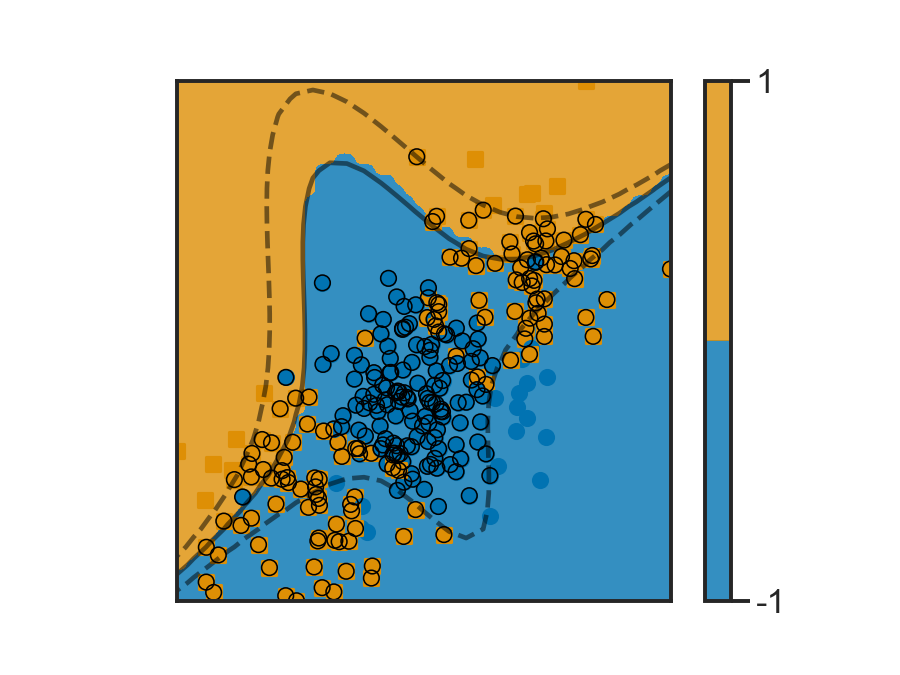

In [13]:
#POLYNOMIAL
plt.close("all")
p_grid_nlsvm = {'C': [1,2,3,4,5,6,7,8,9,1e1,1e2,1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
POLYsvm = SVC(kernel='poly')
grid_polysvm = GridSearchCV(estimator= POLYsvm,param_grid=p_grid_nlsvm, cv=5 )
grid_polysvm.fit(X_train4, y_train4)
print("Best training Score: {}".format(grid_polysvm.best_score_))
print("Best training params: {}".format(grid_polysvm.best_params_))

print("Score for the test set :", grid_polysvm.score(X_test4, y_test4))

train_scorePOLY = grid_polysvm.best_score_
test_scorePOLY = grid_polysvm.score(X_test4, y_test4)


# Plot the boundaries

def f(xx):
    
    """Classifier"""
    return int(grid_polysvm.predict(xx.reshape(1, -1)))
frontiere(f, X_train4, y_train4, w=None, step=50, alpha_choice=1)

# plot the decision function
clf = SVC(kernel='poly',C=grid_polysvm.best_params_["C"],gamma=grid_polysvm.best_params_["gamma"])
clf.fit(X_train4, y_train4)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
      linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

sv_POLY = len(clf.support_vectors_)
plt.show()

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.


First, let's see withe the linear kernel

Best training Score: 0.5666666666666667
Best training params: {'C': 3}
Score for the test set : 0.55


<IPython.core.display.Javascript object>


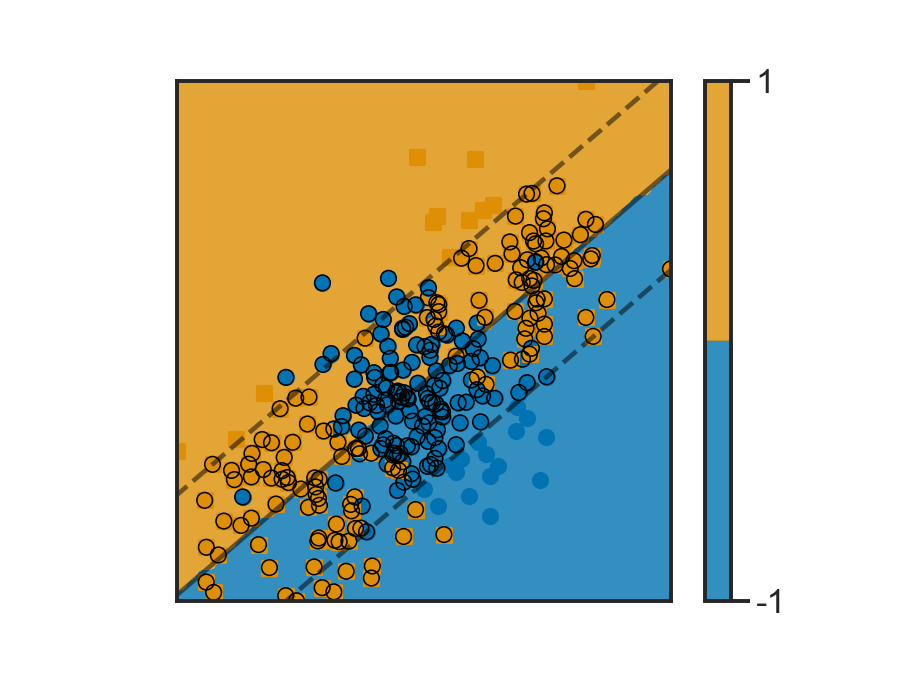

In [14]:
plt.close("all")
p_grid_svm = {'C': [1,2,3,4,5,6,7,8,9,1e1,1e2,1e3]}
LSVM = SVC(kernel='linear')
grid_lsvm = GridSearchCV(estimator= LSVM, param_grid=p_grid_svm, cv=5 )
grid_lsvm.fit(X_train4, y_train4)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

train_scoreL = grid_lsvm.best_score_
test_scoreL =  grid_lsvm.score(X_test4, y_test4)

print("Score for the test set :", grid_lsvm.score(X_test4, y_test4))


def f(xx):
    """Classifier"""
    return int(grid_lsvm.predict(xx.reshape(1, -1)))
frontiere(f, X_train4, y_train4, w=None, step=50, alpha_choice=1)


# plot the decision function
clf = SVC(kernel='linear',C=grid_lsvm.best_params_["C"])
clf.fit(X_train4, y_train4)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
      linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')


sv_L = len(clf.support_vectors_)
plt.show()

<IPython.core.display.Javascript object>


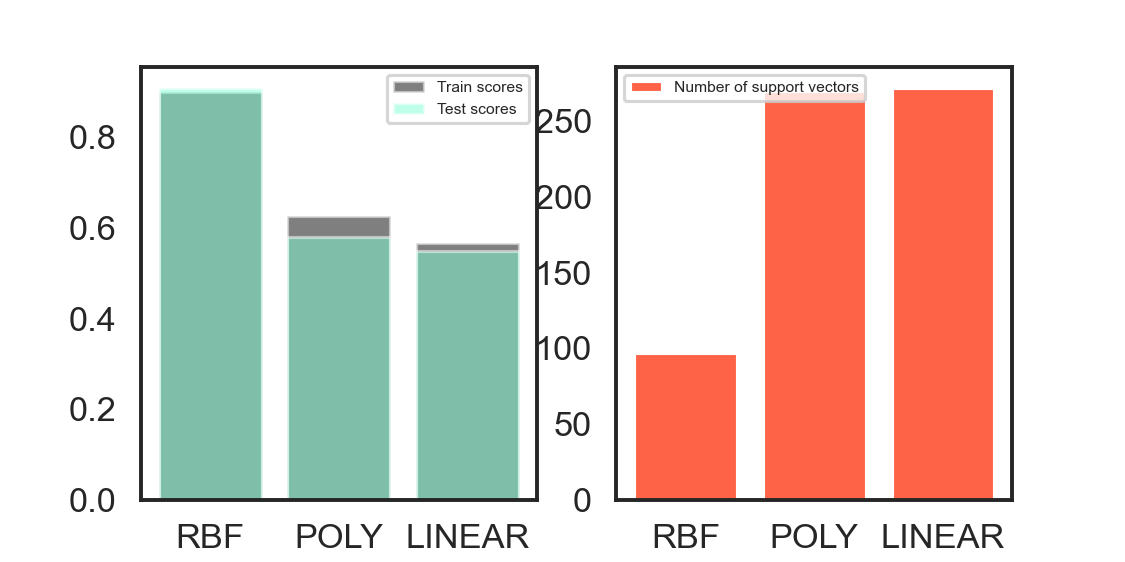

In [15]:
plt.close("all")
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes.ravel()
methods=['RBF','POLY', 'LINEAR']

ax[0].bar(methods, [train_scoreRBF, train_scorePOLY, train_scoreL], label="Train scores", color="black", alpha=0.5)
ax[0].bar(methods, [test_scoreRBF, test_scorePOLY, test_scoreL], label="Test scores", color="aquamarine", alpha=0.5)
ax[0].legend(fontsize = 10)

ax[1].bar(methods,[sv_RBF, sv_POLY, sv_L], label="Number of support vectors", color="tomato" )
ax[1].legend(fontsize = 10)

We can see that the gaussian kernel is the best in accuracy even if sometimes there is a little overfitting. Regarding the polynomial accuracy, it doesn't do overfitting neither but the values are lower than with a gaussian kernel. Here we could think that the linear kernel is good but we have to see the boundaries of the classification to affirm that this model is not well adapted to the data, which is not linearly separable. The number of support vector is much lower with a kernel "rbf".

Gaussian kernel seems to be a good model, and the best here.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

In [16]:
params = grid_nlsvm.best_params_
svmRBF = SVC(kernel='rbf', C = params["C"], gamma = params["gamma"])
sizes = np.arange(10,300,2)
scores = np.zeros((len(sizes), 2))
for k in range(10):
    for i, size in enumerate(sizes) : 
        permutation = np.random.permutation(np.arange(300))
        newX_train = (X_train4[permutation])[:size]
        newy_train = (y_train4[permutation])[:size]
        svmRBF.fit(newX_train, newy_train)
        scores[i][0] += svmRBF.score(newX_train, newy_train)
        scores[i][1] += svmRBF.score(X_test4, y_test4)
scores = scores/10

In [17]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
n_mc = 10000
empiric_risk = 0

for i in range(n_mc):
    rand = np.random.random()
    if rand < 1/2 : 
        x = np.random.multivariate_normal((0,0), 1.5*np.eye(2), 1)
    elif rand < 3/4 : 
        x = np.random.multivariate_normal((3,3), 1.5*np.eye(2), 1)
    else :
        x = np.random.multivariate_normal((-3,-3), 1.5*np.eye(2), 1)
        
    p1 = multivariate_normal.pdf(x, mean = (0,0), cov = 1.5*np.eye(2))
    p2 = 0.5*multivariate_normal.pdf(x, mean = (3,3), cov = 1.5*np.eye(2)) + 0.5*multivariate_normal.pdf(x, mean = (-3,-3), cov = 1.5*np.eye(2))
    eta = 3*p1/4*(p1+p2)
    empiric_risk+= min(eta, 1-eta)
    
empiric_risk = empiric_risk/n_mc

print("Estimated Bayes risk :", empiric_risk)
print("Estimated Bayes accuracy :", 1-empiric_risk)

Estimated Bayes risk : 0.001462368671778418
Estimated Bayes accuracy : 0.9985376313282216


<IPython.core.display.Javascript object>


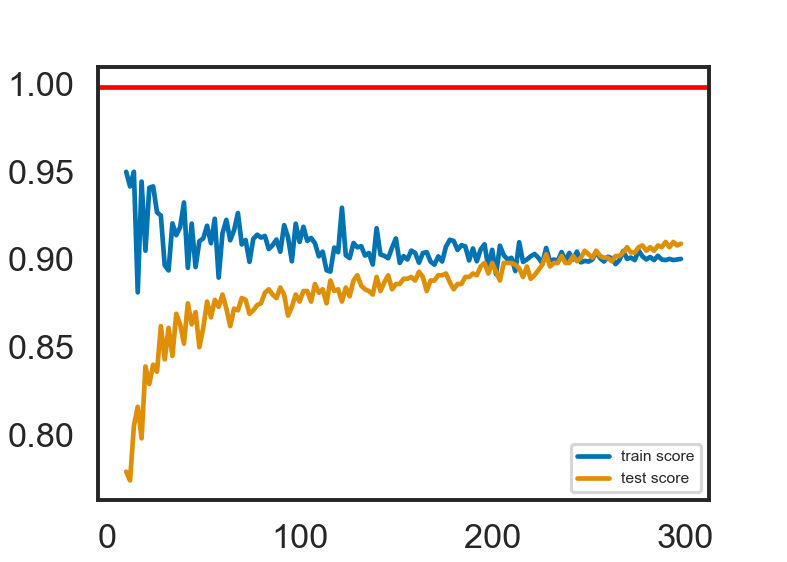

In [18]:
# Add this estimation to the plot of train/test error
plt.close("all")
plt.figure(1, figsize=(7,5))
plt.plot(sizes, scores[:,0], label = "train score")
plt.plot(sizes, scores[:,1], label = "test score")
plt.xlabel("Size of the training set")
plt.axhline(1-empiric_risk, color='r')
plt.legend(fontsize=10)

When the size of the training set increases, the test score increases while the training score decrease a bit until a certain value. It shows that using a large number of data for the training permits to avoid overfitting. 
It seems however strange that the estimated bayes accuracy doesn't correspond to the experimental scores...

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


<IPython.core.display.Javascript object>


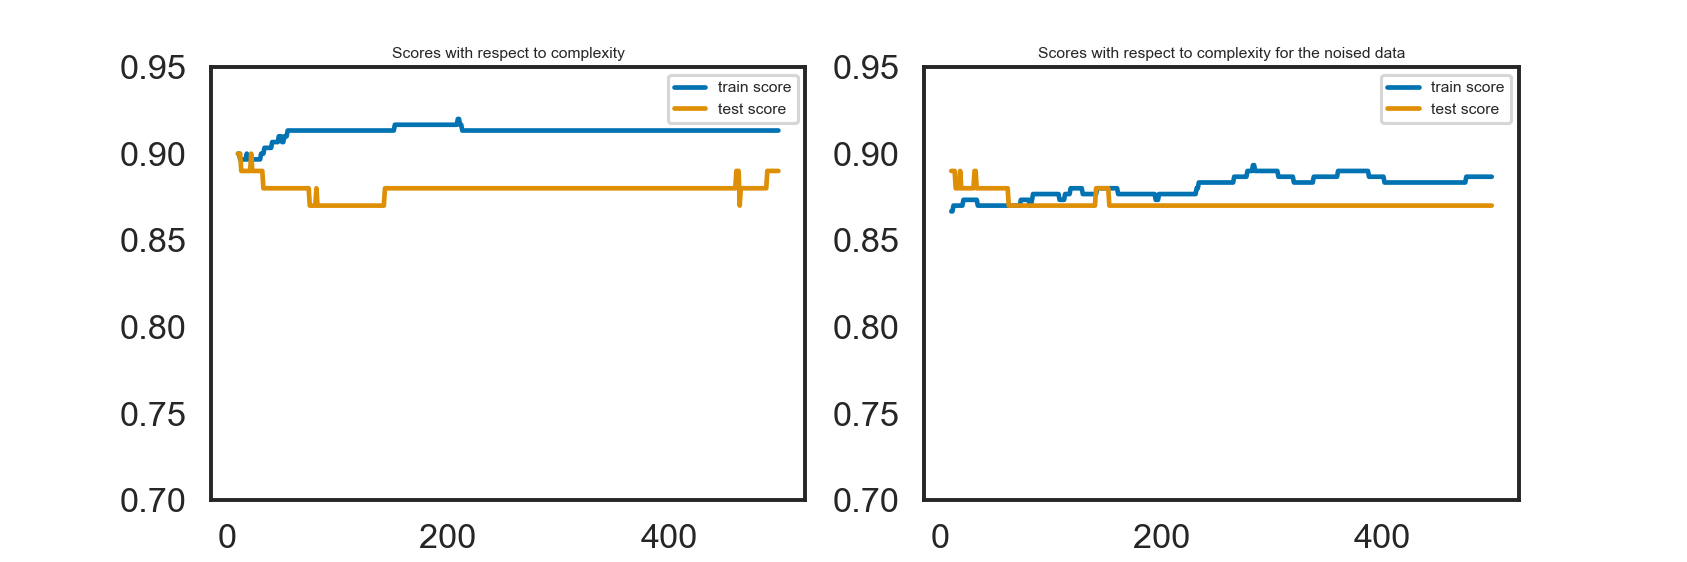

In [20]:
# Modify the class of some data points randomly
k = 15
rd = np.random.randint(150, size=k)
y_train_noise = y_train4.copy()
y_train_noise[rd]=-y_train_noise[rd]
c_params=np.arange(10,500,1)

scores=np.zeros((len(c_params),2))
scores_noise=np.zeros((len(c_params),2))
sv_noise = np.zeros((len(c_params),))
sv = np.zeros((len(c_params),))

for i, c in enumerate(c_params):
    SVMn = SVC(kernel='rbf', C = c, gamma = params["gamma"])
    SVMn.fit(X_train4, y_train_noise)
    scores_noise[i][0] = SVMn.score(X_train4, y_train_noise)
    scores_noise[i][1] = SVMn.score(X_test4, y_test4)
    sv_noise[i]=len(SVMn.support_vectors_)
    
    SVMn.fit(X_train4, y_train4)
    scores[i][0] = SVMn.score(X_train4, y_train4)
    scores[i][1] = SVMn.score(X_test4, y_test4)
    sv[i]=len(SVMn.support_vectors_)
    
    
plt.close("all")
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
ax=axes.ravel()
ax[0].plot(c_params, scores[:,0], label = "train score")
ax[0].plot(c_params, scores[:,1], label = "test score")
ax[0].set_xlabel("C")
ax[0].set_ylim(0.7, 0.95)
ax[0].set_title("Scores with respect to complexity", fontsize=10)
ax[0].legend(fontsize=10, loc=1)


ax[1].plot(c_params, scores_noise[:,0], label = "train score")
ax[1].plot(c_params, scores_noise[:,1], label = "test score")
ax[1].set_xlabel("C")
ax[1].set_ylim(0.7, 0.95)
ax[1].set_title("Scores with respect to complexity for the noised data", fontsize=10)
ax[1].legend(fontsize=10, loc=1)

Globally the train score for the noised data is lower than the original data and the scores for the noised data have more changes. When the complexity increases, the training and test scores stabilize. Moreover the changes of the scores are done in steps, the fonctions are constant by pieces. The test scores are almost the same for the noised and original data

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_
examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

<IPython.core.display.Javascript object>


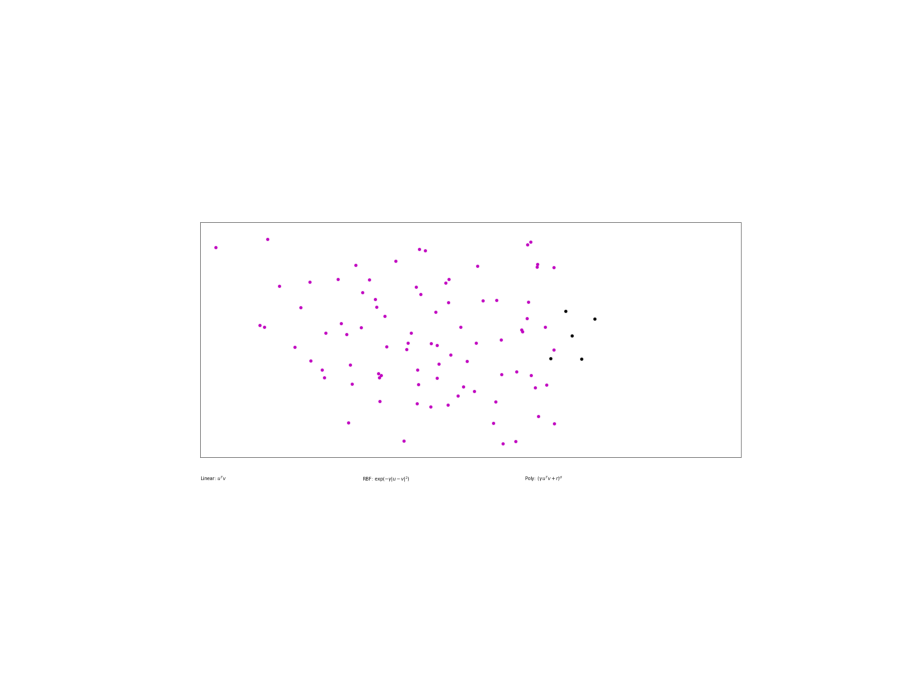

(-0.5, 1535.5, 682.5, -0.5)

In [21]:
from skimage.io import imread
plt.close("all")
plt.imshow(imread("image.png"))
plt.axis("off")

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

<IPython.core.display.Javascript object>


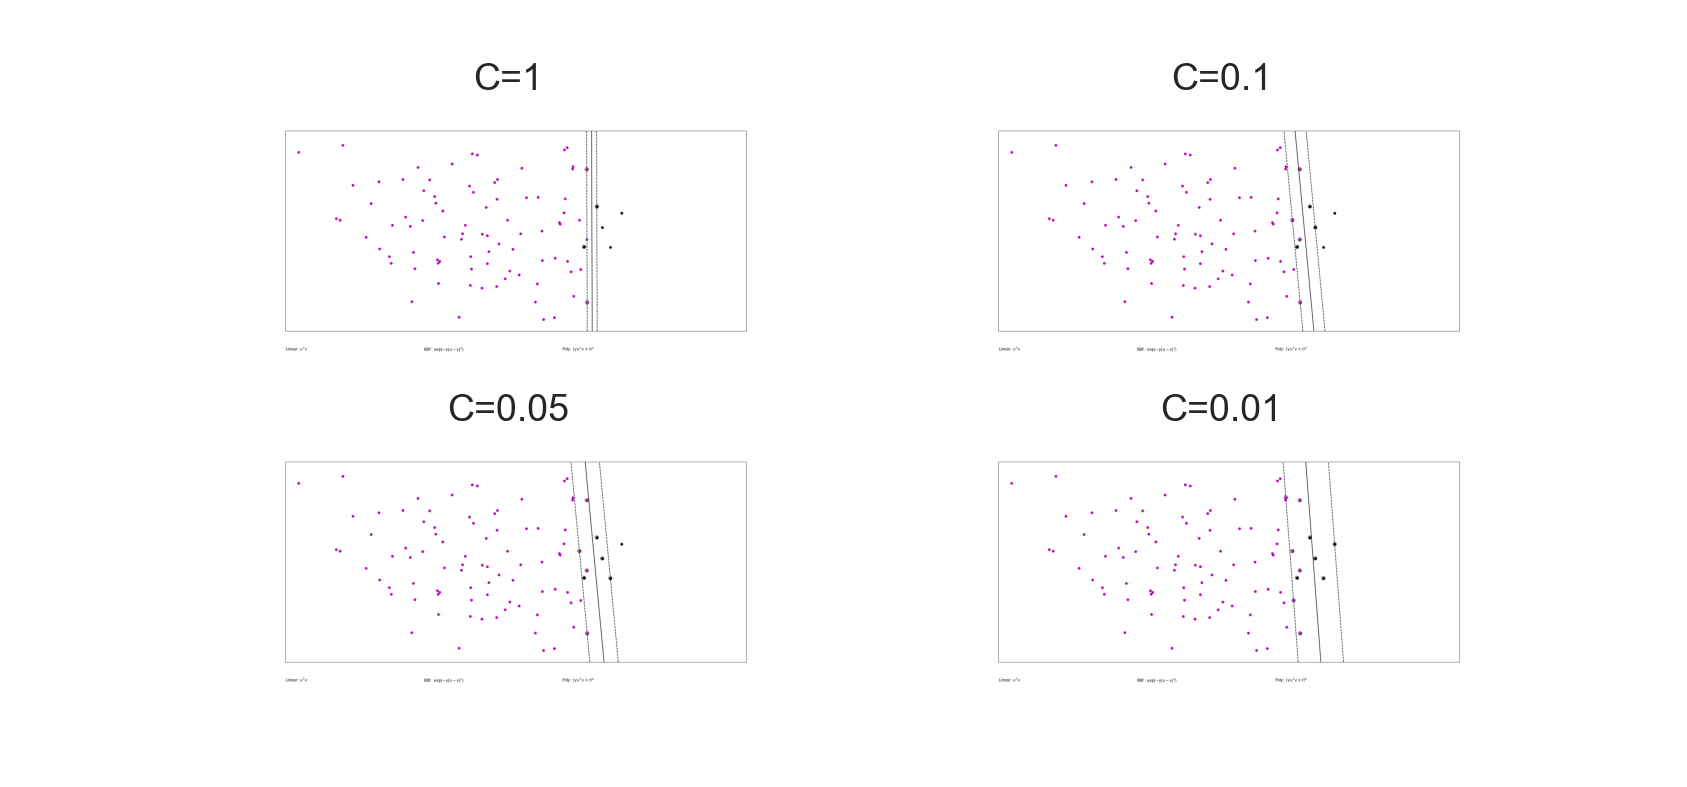

(-0.5, 1535.5, 682.5, -0.5)

In [22]:
C1 = imread("C1.png")
C01 = imread("C0.1.png")
C005 = imread("C0.05.png")
C001 = imread("C0.01.png")
fig, axes = plt.subplots(2,2, figsize=(15, 7))
ax=axes.ravel()

ax[0].imshow(C1)
ax[0].set_title("C=1")
ax[0].axis("off")

ax[1].imshow(C01)
ax[1].set_title("C=0.1")
ax[1].axis("off")

ax[2].imshow(C005)
ax[2].set_title("C=0.05")
ax[2].axis("off")

ax[3].imshow(C001)
ax[3].set_title("C=0.01")
ax[3].axis("off")

When C decreases the computing time becomes short and the margin and the number of support vectors increase. This can be explained by the fact that by decreasing C we regularize less the size of the $\xi$, so they have the possibility to be bigger, so the margin too. And since we regularize less, there are less constraints, the computation time is shorter since it is close to the perceptron algorithm.
Moreover we see that the boundary move to the minority class when C decreases, because we impose less constraint to the model and then the simplest solution is to do that.

## Going further : application to face classification

Code for downloading and organizing the data:

In [2]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features

meanX = X.mean()
stdX = X.std()
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

Fitting the classifier to the training set


<IPython.core.display.Javascript object>


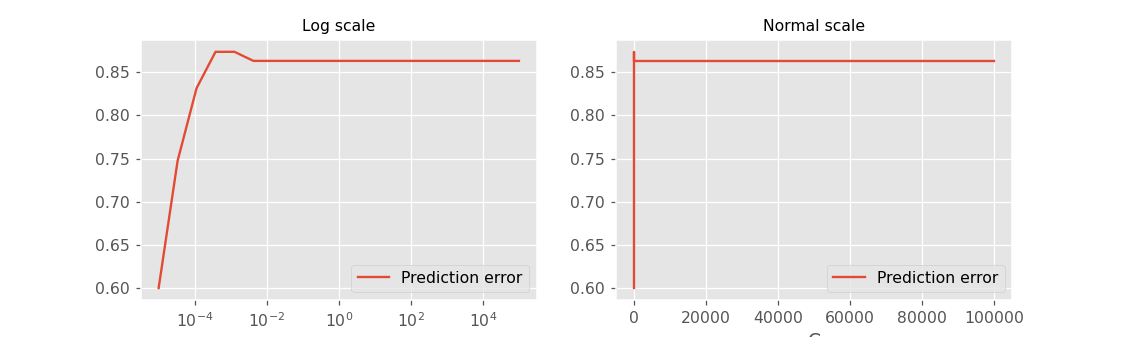

Text(0.5, 1.0, 'Normal scale')

In [3]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()
c_params = np.logspace(-5, 5, 20)
scores = []
for c in c_params:
    clf = svm.SVC(kernel="linear", C=c)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
plt.close("all")

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()
ax[0].plot(c_params, scores, label="Prediction error")
ax[0].set_xscale("log")
ax[0].legend(fontsize=10)
ax[0].set_xlabel("C")
ax[0].set_title("Log scale", fontsize=10)


ax[1].plot(c_params, scores, label="Prediction error")
ax[1].legend(fontsize=10)
ax[1].set_xlabel("C")
ax[1].set_title("Normal scale", fontsize=10)


In [4]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.072s
Chance level : 0.6210526315789474
Accuracy : 0.8631578947368421


<IPython.core.display.Javascript object>


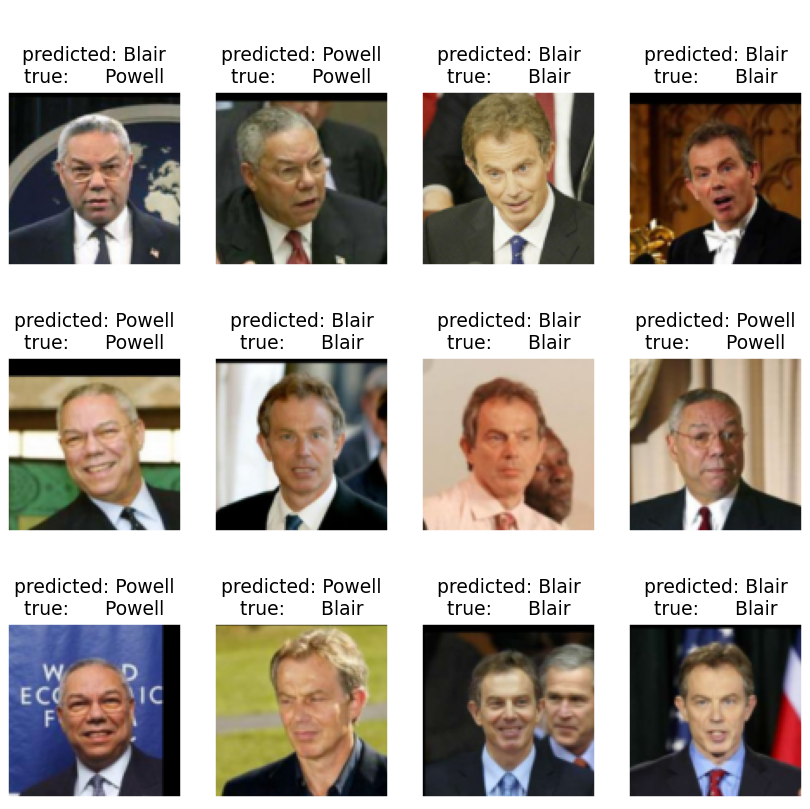

In [5]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

**18)** Explain why the features are centered and reduced.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

**Question 17**

Here, adding features means increasing the dimension of the image vectors. If we want this to disturb the SVM computation, there must be a change in the location of the vectors in this new dimension. So we have to add variables with large values or many new variables to move the clusters and change the performance.

- Example with variables of large values

<IPython.core.display.Javascript object>


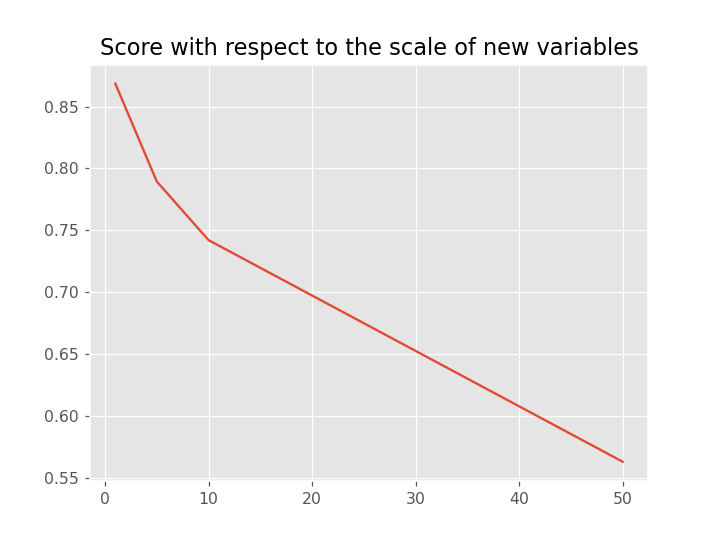

Text(0.5, 1.0, 'Score with respect to the scale of new variables')

In [6]:
scores=[]
for K in [1, 5, 10, 50]:
    # X_train
    X_train_noised = np.zeros((len(X_train), 11000))  # add 2100 random features of value between -K, K
    X_train_noised[:,:10000] = X_train
    for i in range(len(X_train)):
        noise = np.random.randint(-K, K, size=1000)
        X_train_noised[i,10000:] = noise
    
    # X_test
    X_test_noised = np.zeros((len(X_test),11000))
    X_test_noised[:,:10000] = X_test
    for i in range(len(X_test)):
        noise = np.random.randint(-K, K, size=1000)
        X_test_noised[i,10000:] = noise

    clf2 = svm.SVC(kernel="linear", C=1)
    clf2.fit(X_train_noised, y_train)
    scores.append(clf2.score(X_test_noised, y_test))
plt.close("all")
plt.plot([1, 5, 10, 50], scores)
plt.title("Score with respect to the scale of new variables")

- Example with the number of new variables

In [7]:
scores=[]
for size in [10, 100, 1000, 10000, 100000]:
    X_train_noised = np.zeros((len(X_train), 10000+size))  # add 2100 random features of normal distribution
    X_train_noised[:,:10000] = X_train
    for i in range(len(X_train)):
        noise = np.random.randn(size)
        X_train_noised[i,10000:] = noise
    
    # X_test
    X_test_noised = np.zeros((len(X_test),10000+size))
    X_test_noised[:,:10000] = X_test
    for i in range(len(X_test)):
        noise = noise = np.random.randn(size)
        X_test_noised[i,10000:] = noise

    clf2 = svm.SVC(kernel="linear", C=1)
    clf2.fit(X_train_noised, y_train)
    scores.append(clf2.score(X_test_noised, y_test))

<IPython.core.display.Javascript object>


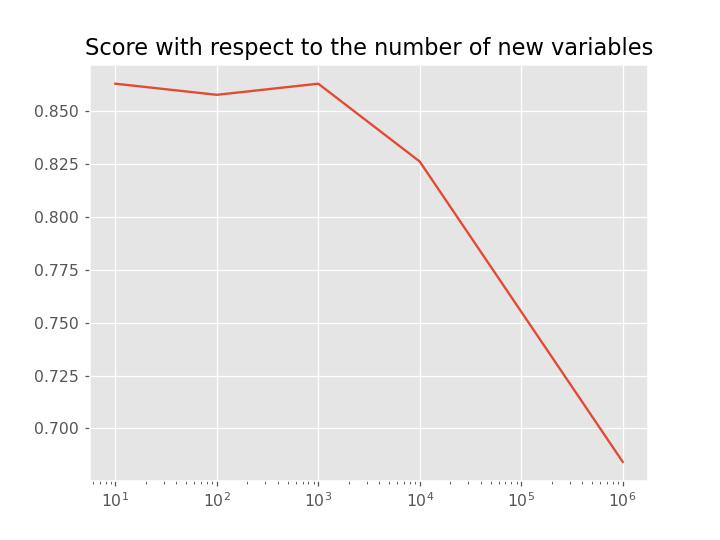

Text(0.5, 1.0, 'Score with respect to the number of new variables')

In [8]:
plt.close("all")
plt.plot([10, 100, 1000, 10000, 1000000], scores)
plt.xscale("log")
plt.title("Score with respect to the number of new variables")

We can indeed see that the performance drops.

**Question 18** : let's test on an example

In [9]:
from sklearn.preprocessing import StandardScaler

X5, y5 = make_blobs(n_samples=100, n_features=2, cluster_std=np.array([[130,20000],[130,20000]]),
                  centers=[(900,50000),(1200,10000)], shuffle=False)

y5[:50]=-1
i=np.random.randint(100)
np.random.seed(i)
np.random.shuffle(y5)
np.random.seed(i)
np.random.shuffle(X5)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.25)

scaler = StandardScaler()
X_train5_sc = scaler.fit_transform(X_train5)

<IPython.core.display.Javascript object>


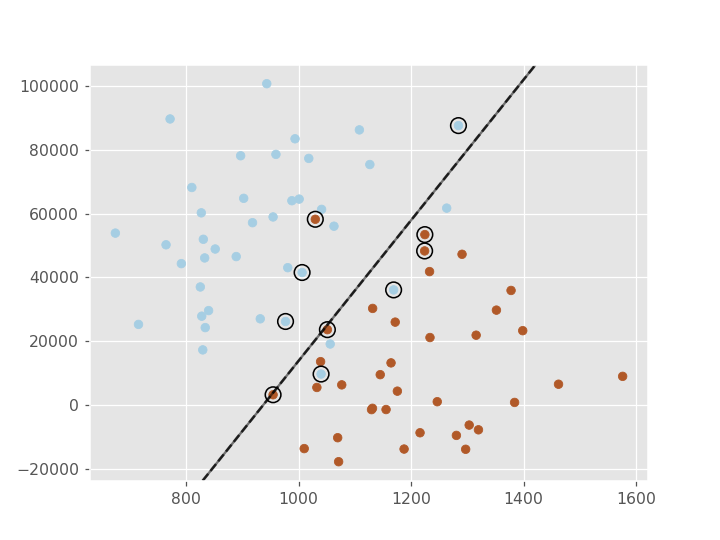

<IPython.core.display.Javascript object>


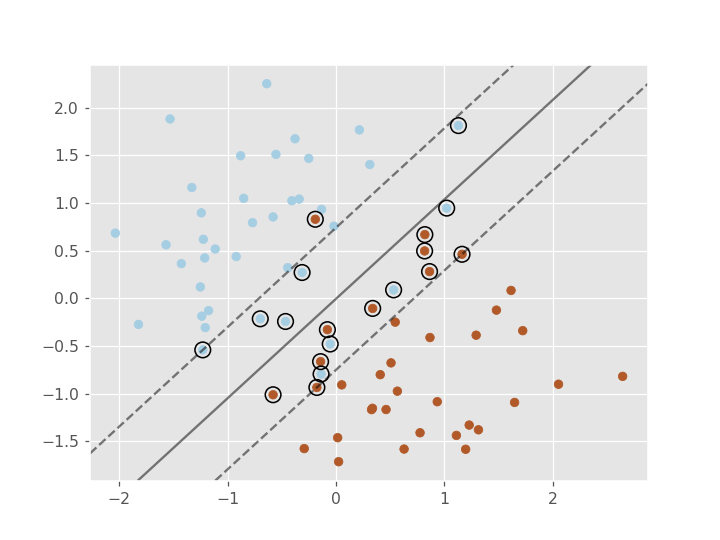

In [10]:
plt.close("all")
X_trains = [X_train5, X_train5_sc]
for i in range(2) :
    plt.figure(i)
    plt.scatter((X_trains[i])[:, 0], (X_trains[i])[:, 1], c=y_train5, s=30, cmap=plt.cm.Paired)
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    clf=SVC(kernel="linear")
    clf.fit((X_trains[i]), y_train5)

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
          linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

First we see that if the values are not scaled, the margin boudaries seem very small since the points have large values, so in the calculation it may be more sensitive to variation of C.

Moreover in general case SVM minimizes the coeff of w, and the solution depends on the values of X so if there is difference between features, the coefficients of w will be influenced by this gap. It is important to center and reduce the values so that there are no big difference of importantce between the features. 

For instance with the images, there are some areas where the pixels are closed to zero (on the edges of because of the cropping), and other close to 255 (on lighted areas).In addition, the images have different lighting. So it is important to scaled the images.

**Question 19** :

In [11]:
clf3 = SVC(C=1)
t0 = time()
clf3.fit(X_train, y_train)

print("done in %0.3fs" % (time() - t0))
print("Train accuracy : %s" % clf3.score(X_train, y_train))
print("Test accuracy : %s" % clf3.score(X_test, y_test))

done in 0.148s
Train accuracy : 0.9842105263157894
Test accuracy : 0.7684210526315789


The accuracy is lower here, it does overfitting. Since the number of pixel is already big, non-linear SVM will increase the dimension when it is maybe not needed. Here we have a high dimension and I don't think that wee need to increase it more to separate the two clusters of images. Maybe if we reduce the dimension (by choosing the most important features) before doing non-linear SVM, we will improve the accuracy. 

In [12]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(n_components = 190)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

clf3 = SVC()
t0 = time()
clf3.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Train accuracy : %s" % clf3.score(X_train_pca, y_train))
print("Test accuracy : %s" % clf3.score(X_test_pca, y_test))

done in 0.004s
Train accuracy : 0.9842105263157894
Test accuracy : 0.7894736842105263


We have indeed a better result than before